In [1]:
import torch

import matplotlib
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm

# View available fonts
# for font in fm.findSystemFonts(fontpaths = None, fontext = 'ttf'):
#    print(fm.FontProperties(fname = font).get_name())

# Set font properties
matplotlib.rcParams['mathtext.fontset'] = 'stix'
# matplotlib.rcParams['font.family'] = 'Nimbus Roman'
matplotlib.rcParams['font.family'] = 'P052'

In [2]:
# define properties of distribution in scientific notation
locs = torch.tensor([[-1., 0.], [1., 0.]])
scales = torch.tensor([
    [0.4, 0.8], # in x1 and x2 directions
    [0.6, 0.6]]) # in x1 and x2 directions
mixture_weights = torch.tensor([0.5, 0.5])

In [3]:
def mixture_of_gaussians_logprob(locs, scales, mixture_weights):
    """
    Returns a function that computes the log-probability of a Mixture of Gaussians at given points.
    
    Args:
        locs: Tensor of shape [K, D], where K is the number of Gaussians, D is the dimension.
        scales: Tensor of shape [K, D], standard deviations for each Gaussian.
        mixture_weights: Tensor of shape [K], mixture weights (should sum to 1, but we renormalise).
        
    Returns:
        A function that takes input x of shape [N, D] and returns log-probs [N].
    """
    def logprob(x):
        """
        Computes the log-probability of the Mixture of Gaussians at points x.
        """
        # Extract last dimension 
        D = x.shape[-1]
        
        # Log of normalized mixture probabilities
        log_probs = torch.log(mixture_weights / mixture_weights.sum())  # shape: [K]
        log_probs = log_probs.unsqueeze(0)  # shape: [1, K]
        
        # Compute differences between each x and each component mean
        # x: [N, D], locs: [K, D] -> diff: [N, K, D]
        diff = x.unsqueeze(1) - locs.unsqueeze(0)  # shape: [N, K, D]
        
        # Quadratic term of Gaussian
        quad = -0.5 * torch.sum((diff / scales) ** 2, dim = 2)  # shape: [N, K]
        
        # Log of normalizing constant
        log_norm = -0.5 * D * torch.log(2 * torch.tensor(torch.pi)) \
                   - torch.sum(torch.log(scales), dim = -1)  # shape: [K]
        log_norm = log_norm.unsqueeze(0)  # shape: [1, K]
        
        # Full component log probs
        component_log_probs = log_probs + quad + log_norm  # shape: [N, K]
        
        # Log-sum-exp trick
        max_val, _ = torch.max(component_log_probs, dim = 1, keepdim = True)
        log_sum_exp = max_val + torch.log(torch.sum(torch.exp(component_log_probs - max_val), dim = 1, keepdim = True))
        
        return log_sum_exp.squeeze(1)  # shape: [N]
    
    return logprob

# Create log-probabilty lambda (function object) with our defined properties
logprob = mixture_of_gaussians_logprob(
    locs = locs,
    scales = scales,
    mixture_weights = mixture_weights,
)

In [4]:
grid_res = 100
x_plot = torch.linspace(-2.5, 2.5, grid_res)

XX, YY = torch.meshgrid(x_plot, x_plot, indexing = 'xy')
x_plot = torch.stack([XX, YY], dim = -1) # shape: [grid_res, grid_res, 2]
x_plot_flat = x_plot.view(-1, 2) # shape: [grid_res * grid_res, 2]

# Pass flat (N, D) tensor to logprob function
logp_flat = logprob(x_plot_flat) # shape: [grid_res * grid_res]
logp = logp_flat.reshape(grid_res, grid_res) # shape: [grid_res, grid_res]

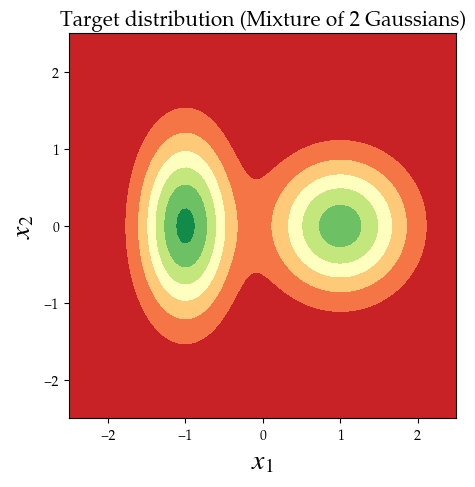

In [5]:
plt.figure(figsize = (5, 5))
plt.contourf(
    x_plot[:, :, 0],
    x_plot[:, :, 1],
    torch.exp(logp), # transform back to probabilities
    cmap = "RdYlGn",
)

# Format plot
plt.xlabel('$x_1$', fontsize = 20)
plt.ylabel('$x_2$', fontsize = 20)
plt.title('Target distribution (Mixture of 2 Gaussians)', fontsize = 15)
plt.show()

In [6]:
# Kernel function with adaptive lengthscale
def kernel(x):
    """ Calculate the kernel matrix between x and x_ (itself) using the squared exponential kernel. We define the function like this - with one input - for the to be able to apply the functional jacobian from torch"""
    
    # Create a version of x to use as the "reference" set in the kernel (self-referential)
    x_ = x.detach().clone().requires_grad_(True)  # shape: [N, D]

    # Compute pairwise differences between all points in x and x_ via broadcasting
    # Resulting shape: [N, N, D] where N = x.shape[0], thus also N = x_.shape[0]
    diff = x[:, None, :] - x_[None, :, :]
    sq_dist = (diff ** 2).sum(dim = 2) # no ARD

    # Normalize differences by lengthscales, then square and sum across dimensions
    # This computes the squared Mahalanobis distance
    # bandwidth (h) = 2 * lengthscales ** 2
    h = torch.median(sq_dist.reshape(-1)).item() # median across all dims
    h = 0.5 * h / torch.log(torch.tensor(x.shape[0] + 1, dtype = torch.float32))
    h = torch.sqrt(h)

    sq_dist_scaled = sq_dist / h**2 / 2 # shape: [N, N]. As in original code?! not quite consistent

    # Apply the exponential to get the RBF kernel values
    exp = torch.exp(- sq_dist_scaled)  # shape: [N, N]

    return exp  # Kernel matrix between x and x_

def svgd_grad(x, logprob, kernel):
    """
    Compute the Stein Variational Gradient for a set of particles.

    Args:
        x (torch.Tensor): Particles, shape [N, D], where N is the number of particles and D is the dimensionality.
        logprob (callable): Function that returns log-probability for a batch of inputs.
        kernel (callable): Kernel function that takes two inputs (x, x_) and returns a [N, N] kernel matrix.

    Returns:
        torch.Tensor: SVGD update directions, shape [N, D]
    """
    # Clone x and ensure gradients are tracked
    x = x.detach().clone().requires_grad_(True)

    # Extract number of particles for normalisation
    N = x.shape[0]

    # Compute the kernel matrix K between particles (pair-wise)
    k = kernel(x)  # shape: [N, N]

    ### ATTRACTIVE FORCE (CONSENSUS) ###
    # Compute the gradient of logp w.r.t. particles x
    # In which direction does the log-probability increase?
    # Jacobian outputs [N, N, D] where only the diagonal of [N, N] is non-zero. Flip dims to get [N, D]
    dlogp = torch.autograd.functional.jacobian(logprob, x).diagonal(dim1 = 0, dim2 = 1).permute(1, 0)  # shape: [N, D]

    ### REPULSIVE FORCE (DIVERSITY) ###
    # pairwise squared Euclidean distances
    diff = x[:, None, :] - x[None, :, :] # shape: [N, N, D]
    # squared (Euclidean) distance
    sq_dist = (diff ** 2).sum(dim = -1) # shape: [N, N]
    h = median_heuristic(x)
    # gradient w.r.t. x is negative
    dk = (2 / h * diff * k.unsqueeze(-1)).sum(dim = 1)  # shape: [N, D]

    # Compute the SVGD update direction
    # First term: attractive force (consensus), second term: repulsive force (diversity)
    svg = (torch.matmul(k, dlogp) + dk) / N  # shape: [N, D]

    return svg, k, dlogp, dk

def median_heuristic(x):
    """
    Compute the median heuristic bandwidth for RBF kernel.
    
    Args:
        x (torch.Tensor): Tensor of shape [N, D]
    
    Returns:
        float: Bandwidth h
    """
    with torch.no_grad():
        # Compute pairwise squared distances
        x_norm = (x ** 2).sum(dim = 1).view(-1, 1)
        dists = x_norm + x_norm.T - 2 * x @ x.T

        # Get upper triangular (excluding diagonal) to avoid duplicates and zeros
        dists = dists[torch.triu(torch.ones_like(dists), diagonal = 1) == 1]

        # Return median of distances
        h = torch.median(dists)

        # h = torch.sqrt(h)

    return h.item()

Notes:

- Jacobian implementation might not be the fastest but I am familar with it

In [7]:
### INITIALISE PARTICLES ###
# Number of particles to simulate
num_particles = 100

# Initial positions of particles
### THIS IS THE ONLY CHANGE: repeat with uniformly distributed particles
x_initial = torch.rand(num_particles, 2) * 4 - 2

# Create EQ kernel
stepsize = 0.1 # 1e-1 as in notebook
num_steps = 10

# svg is phi in the original paper
svg, k, dlogp, dk = svgd_grad(x = x_initial, logprob = logprob, kernel = kernel)

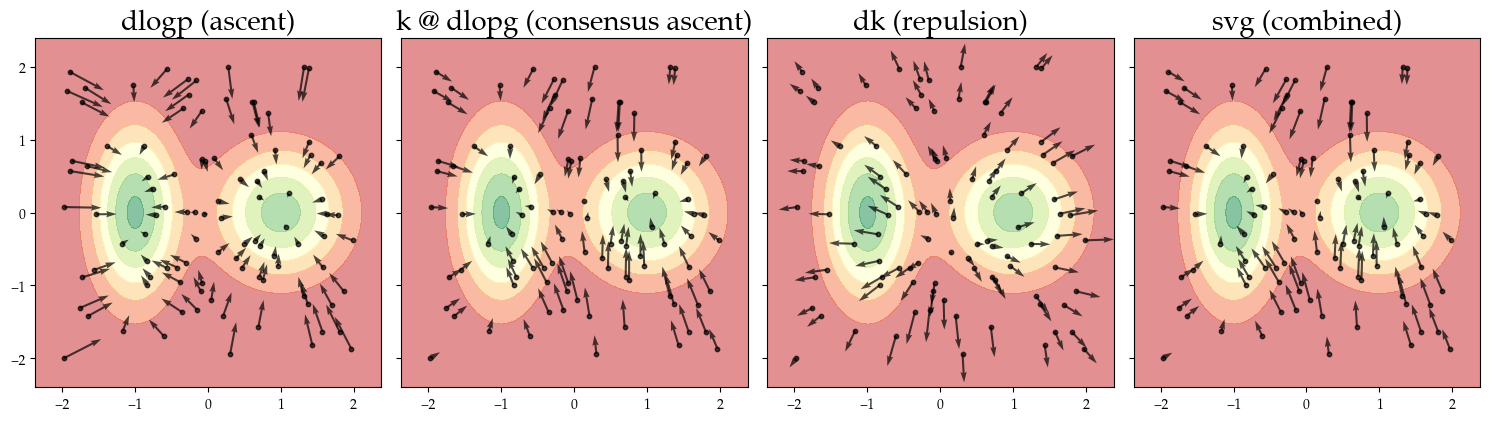

In [8]:
import matplotlib.pyplot as plt

# Detach everything for plotting
x_np = x_initial.detach().numpy()
dlogp_np = dlogp.detach().numpy() / num_particles # normalise by number of particles
dlogp_np = dlogp.detach().numpy()
k_dlogp_np = (k @ dlogp).detach().numpy() / num_particles
dk_np = dk.detach().numpy() / num_particles # negate
svgd_np = svg.detach().numpy()

# Limits
buffer_ratio = 0.1

x_min, x_max = x_np[:, 0].min(), x_np[:, 0].max()
y_min, y_max = x_np[:, 1].min(), x_np[:, 1].max()

x_range = x_max - x_min
y_range = y_max - y_min

x_lim = (x_min - buffer_ratio * x_range, x_max + buffer_ratio * x_range)
y_lim = (y_min - buffer_ratio * y_range, y_max + buffer_ratio * y_range)


fig, axes = plt.subplots(1, 4, figsize = (15, 5), sharex = True, sharey = True)

titles = ["dlogp (ascent)", "k @ dlopg (consensus ascent)", "dk (repulsion)", "svg (combined)"]
vectors = [dlogp_np, k_dlogp_np, dk_np, svgd_np]

for ax, title, vec in zip(axes, titles, vectors):
    ax.contourf(x_plot[:, :, 0], x_plot[:, :, 1], torch.exp(logp), cmap = "RdYlGn", alpha = 0.5)
    ax.scatter(x_np[:, 0], x_np[:, 1], color = 'black', s = 10, label = 'Particles', alpha = 0.7)
    ax.quiver(x_np[:, 0], x_np[:, 1], vec[:, 0], vec[:, 1],
              angles = 'xy', scale_units = 'xy', color = 'black', alpha = 0.7)
    ax.set_title(title, fontsize = 20)
    ax.set_aspect('equal', adjustable = 'box')
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

plt.tight_layout()
plt.show()

The repulsion term is on a much smaller scale than the censensus ascent term.

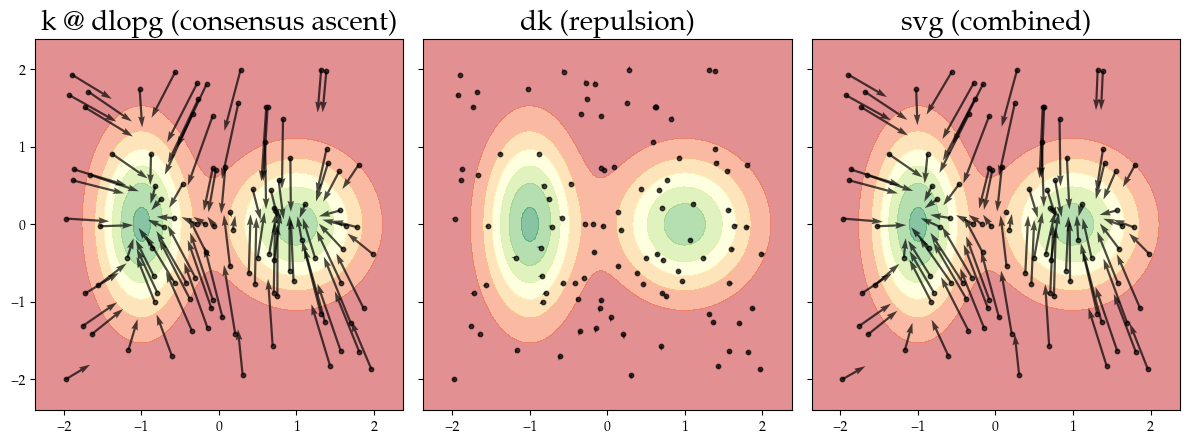

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Detach everything for plotting
x_np = x_initial.detach().numpy()
dlogp_np = dlogp.detach().numpy() / num_particles # normalize by number of particles
dlogp_np = dlogp.detach().numpy()
k_dlogp_np = (k @ dlogp).detach().numpy() / num_particles
dk_np = dk.detach().numpy() / num_particles # negate
svgd_np = svg.detach().numpy()

# Limits
buffer_ratio = 0.1

x_min, x_max = x_np[:, 0].min(), x_np[:, 0].max()
y_min, y_max = x_np[:, 1].min(), x_np[:, 1].max()

x_range = x_max - x_min
y_range = y_max - y_min

x_lim = (x_min - buffer_ratio * x_range, x_max + buffer_ratio * x_range)
y_lim = (y_min - buffer_ratio * y_range, y_max + buffer_ratio * y_range)

# Calculate the maximum length of the vectors for uniform scaling
max_vector_magnitude = 0
for vec in [k_dlogp_np, dk_np, svgd_np]:
    magnitude = np.linalg.norm(vec, axis=1)  # Calculate magnitude of each vector
    max_vector_magnitude = max(max_vector_magnitude, np.max(magnitude))

# Define the quiver scale factor based on the maximum magnitude
scale_factor = max_vector_magnitude

# Plot
fig, axes = plt.subplots(1, 3, figsize = (12, 5), sharex=True, sharey=True)

titles = ["k @ dlopg (consensus ascent)", "dk (repulsion)", "svg (combined)"]
vectors = [k_dlogp_np, dk_np, svgd_np]

for ax, title, vec in zip(axes, titles, vectors):
    ax.contourf(x_plot[:, :, 0], x_plot[:, :, 1], torch.exp(logp), cmap="RdYlGn", alpha=0.5)
    ax.scatter(x_np[:, 0], x_np[:, 1], color='black', s=10, label='Particles', alpha=0.7)
    ax.quiver(x_np[:, 0], x_np[:, 1], vec[:, 0], vec[:, 1],
              angles='xy', scale_units='xy', color='black', alpha=0.7,
              scale=scale_factor)  # Apply uniform scaling factor
    ax.set_title(title, fontsize=20)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

plt.tight_layout()
plt.show()


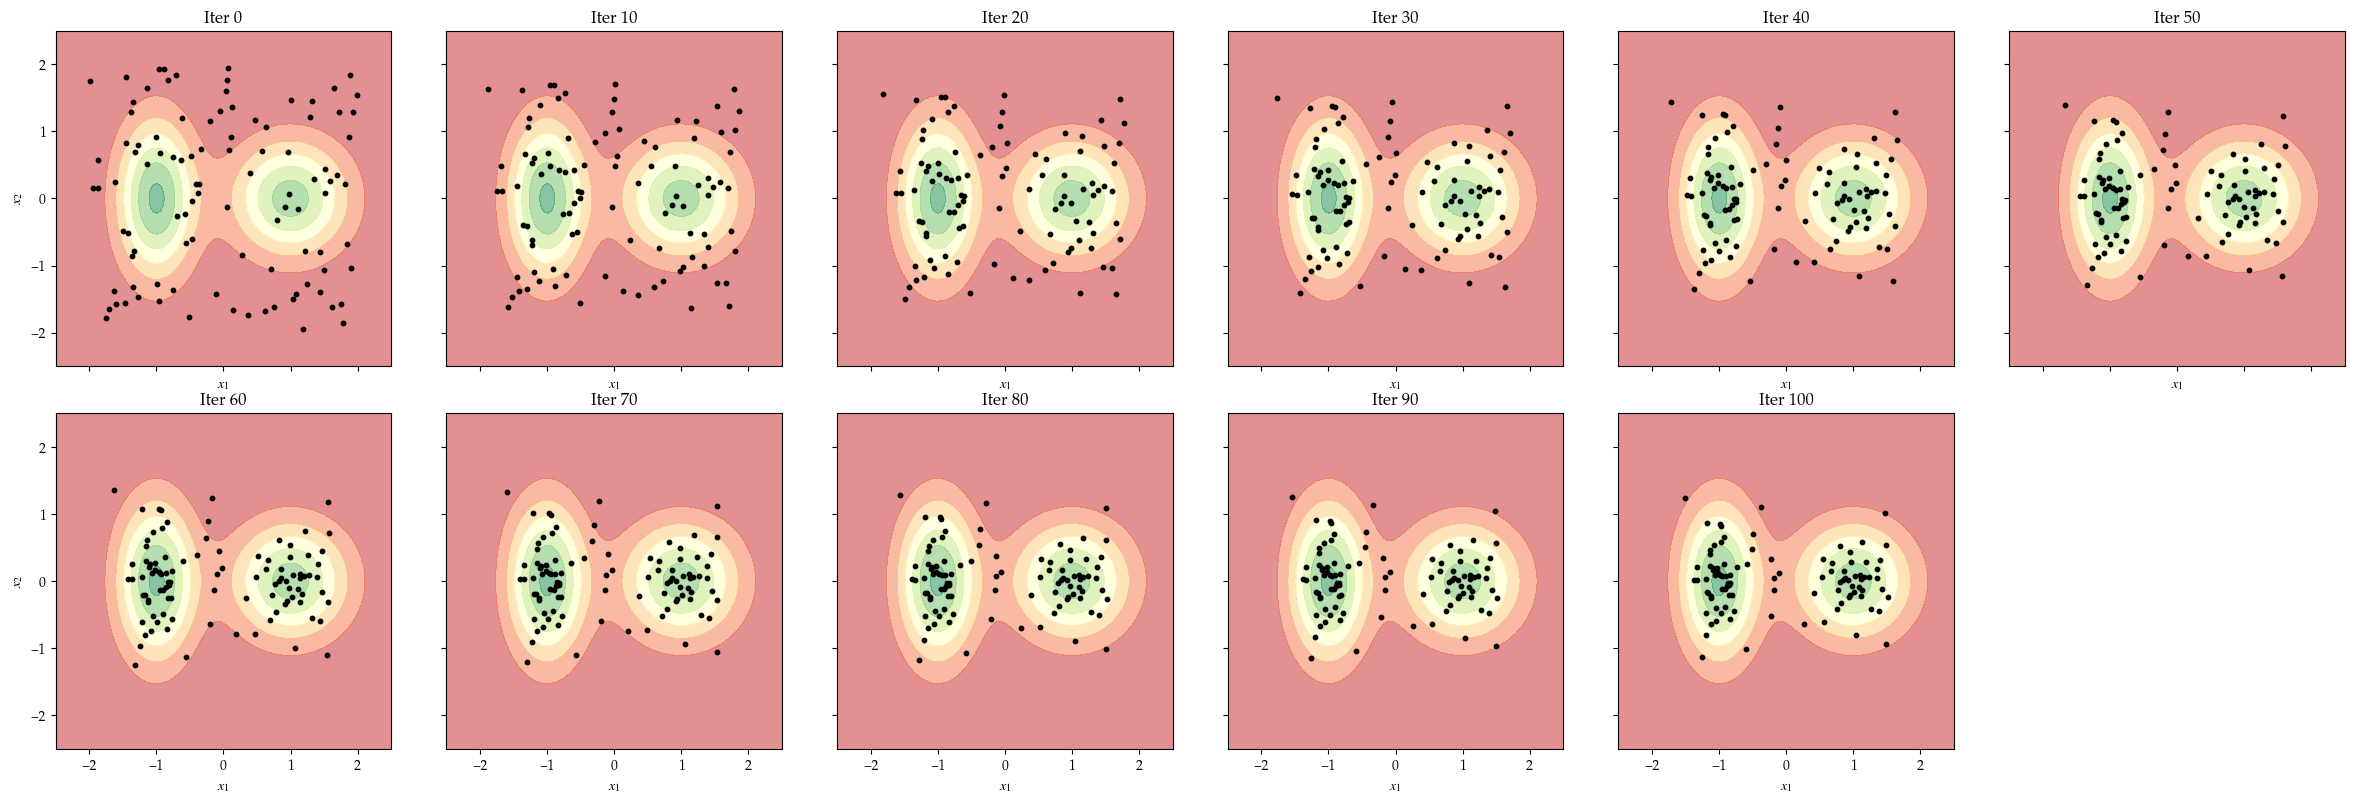

In [10]:
import torch
import matplotlib.pyplot as plt
import math

# Number of particles
num_particles = 100

# Initial positions (uniform in [-2, 2])
x_initial = torch.rand(num_particles, 2) * 4 - 2
x = x_initial.clone()

stepsize = 0.1
num_steps = 100
plot_interval = 10
plot_steps = list(range(0, num_steps + 1, plot_interval))
num_plots = len(plot_steps)

# Arrange plots in 2 rows
n_rows = 2
n_cols = math.ceil(num_plots / n_rows)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten in case it's a 2D array

for i in range(num_steps + 1):
    if i % plot_interval == 0:
        ax_idx = plot_steps.index(i)
        ax = axes[ax_idx]

        ax.scatter(x[:, 0], x[:, 1], zorder=2, c='k', s=10, label='Particles')
        ax.contourf(x_plot[:, :, 0], x_plot[:, :, 1], torch.exp(logp), cmap="RdYlGn", alpha=0.5)
        ax.set_title(f'Iter {i}')
        ax.set_xlabel('$x_1$')
        ax.set_aspect('equal')
        if ax_idx % n_cols == 0:
            ax.set_ylabel('$x_2$')

    # SVGD update
    svg, _, _, _ = svgd_grad(x=x, logprob=logprob, kernel=kernel)
    x = x + stepsize * svg.detach()

# Hide any unused subplots
for j in range(len(plot_steps), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()